# 目标检测数据集

目标检测领域没有像MNIST和Fashion-MNIST那样的小数据集。
为了快速测试目标检测模型，[**我们收集并标记了一个小型数据集**]。
首先，我们拍摄了一组香蕉的照片，并生成了1000张不同角度和大小的香蕉图像。
然后，我们在一些背景图片的随机位置上放一张香蕉的图像。
最后，我们在图片上为这些香蕉标记了边界框。

## [**下载数据集**]

包含所有图像和CSV标签文件的香蕉检测数据集可以直接从互联网下载。


In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

## 读取数据集

通过`read_data_bananas`函数，我们[**读取香蕉检测数据集**]。
该数据集包括一个的CSV文件，内含目标类别标签和位于左上角和右下角的真实边界框坐标。


In [3]:
def read_data_bananas(is_train=True):
    """
    读取香蕉检测数据集中的图像和标签。

    参数:
        is_train (bool): 指示是否读取训练集数据。如果为 True，读取训练集数据；否则读取验证集数据。

    返回:
        images (list): 包含图像数据的列表，每个元素是一个 PyTorch 张量表示的图像。
        targets (Tensor): 包含标签信息的张量，其形状为 (样本数, 1, 5)，其中每个元素对应一个图像的标签。
                          标签的格式为 (类别, 左上角x, 左上角y, 右下角x, 右下角y)。
    """
    # 指定数据集的根目录，并下载/提取数据集
    data_dir = d2l.download_extract('banana-detection')
    
    # 构建 CSV 文件路径，包含图像和标签信息
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    
    # 使用 Pandas 读取 CSV 文件，将其存储为 DataFrame
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    
    # 初始化用于存储图像和标签的列表
    images, targets = [], []
    
    # 遍历每个图像及其标签信息
    for img_name, target in csv_data.iterrows():
        # 读取图像并转换为 PyTorch 张量，将其添加到 images 列表中
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        
        # 将标签信息转换为列表，并添加到 targets 列表中
        targets.append(list(target))
    
    # 将标签列表转换为张量，并进行归一化（除以 256）
    return images, torch.tensor(targets).unsqueeze(1) / 256


通过使用`read_data_bananas`函数读取图像和标签，以下`BananasDataset`类别将允许我们[**创建一个自定义`Dataset`实例**]来加载香蕉检测数据集。


In [4]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""

    def __init__(self, is_train):
        """
        构造函数，初始化 BananasDataset 对象。

        参数:
            is_train (bool): 指示是否加载训练集数据。如果为 True，加载训练集数据；否则加载验证集数据。
        """
        # 调用 read_data_bananas 函数加载图像和标签数据
        self.features, self.labels = read_data_bananas(is_train)
        
        # 打印加载的样本数量信息
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        """
        获取指定索引位置的图像和标签。

        参数:
            idx (int): 图像和标签的索引。

        返回:
            tuple: 包含两个元素的元组，第一个元素是图像的 PyTorch 张量，第二个元素是标签的 PyTorch 张量。
        """
        # 返回指定索引位置的图像和标签
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        """
        返回数据集的长度，即数据集中包含的样本数量。

        返回:
            int: 数据集的长度。
        """
        # 返回数据集的样本数量
        return len(self.features)


最后，我们定义`load_data_bananas`函数，来[**为训练集和测试集返回两个数据加载器实例**]。对于测试集，无须按随机顺序读取它。


In [5]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

让我们[**读取一个小批量，并打印其中的图像和标签的形状**]。
图像的小批量的形状为（批量大小、通道数、高度、宽度），看起来很眼熟：它与我们之前图像分类任务中的相同。
**标签的小批量的形状为（批量大小，$m$，5），其中$m$是数据集的任何图像中边界框可能出现的最大数量。**

**小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。**
通常来说，图像可能拥有不同数量个边界框；因此，在达到$m$之前，边界框少于$m$的图像将被非法边界框填充。
**这样，每个边界框的标签将被长度为5的数组表示。**
数组中的第一个元素是边界框中对象的类别，其中-1表示用于填充的非法边界框。
数组的其余四个元素是边界框左上角和右下角的（$x$，$y$）坐标值（值域在0～1之间）。
对于香蕉数据集而言，由于每张图像上只有一个边界框，因此$m=1$。


In [6]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

## [**演示**]

让我们展示10幅带有真实边界框的图像。
我们可以看到在所有这些图像中香蕉的旋转角度、大小和位置都有所不同。
当然，这只是一个简单的人工数据集，实践中真实世界的数据集通常要复杂得多。


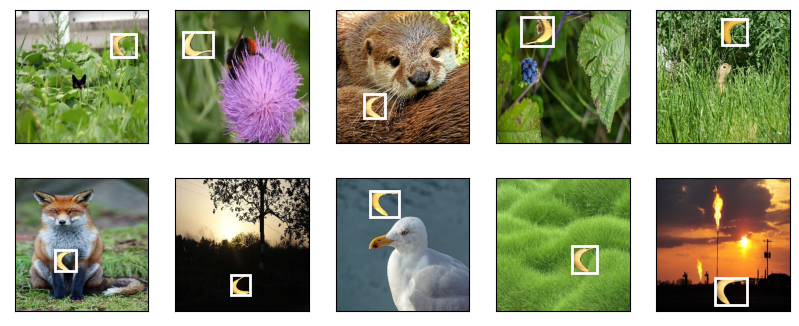

In [7]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## 小结

* 我们收集的香蕉检测数据集可用于演示目标检测模型。
* 用于目标检测的数据加载与图像分类的数据加载类似。但是，在目标检测中，标签还包含真实边界框的信息，它不出现在图像分类中。
